# Makemore - MLP

![MLP architecture](/images/mlp_bengio03.png)

- This implementation is based on [(Bengio et al., 2003)](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf). While it was not the first paper to propose MLP to predict the next token in a sequence, it was one of the most influential.
    - **Embedding**: embed each of the ~17,000 words in the vocabulary into a 30-D continuous feature space. Initially, the words are embedded randomly. Then the embedding weights are learned during training. After training, words with similar meanings end up closer in the embedding space and words with dissimilar meanings move apart. The embedding look-up table `C` is a `17,000 x 30` matrix. Each row is a 30-D vector representing a word in the vocabulary.
    - **Model**: an MLP to predict the next word in the sequence, given 3 previous words. Each word is a 30-D vector, so the input is a 90-D vector. Each tanh-neuron in the hidden layer is fully-connected to the 90 input neurons. The output layer has 17,000 neurons, fully-connected to the hidden layer neurons.
    - **Loss**: maximize the log-likelihood of the training dataset or minimize the average negative log-likelihood.
    - **Optimization**: both the embedding and the network parameters are learned using back-propagation.
- **Why does it work?**: even if during inference, you encounter sentences you have never seen in the training dataset, you can still look for semantically similar sentences in the training dataset and use them to predict the next word. This is why good embeddings are important.


In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

seed = 1234

## Examine and prepare the training dataset

In [2]:
names = open("names.txt").read().split("\n")

In [3]:
names[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
print(f"Total number of names: {len(names):,}")

Total number of names: 32,033


In [5]:
vocab = ["."] + sorted(set([char for name in names for char in name]))
char_to_ix = {char: ix for ix, char in enumerate(vocab)}
ix_to_char = {ix: char for ix, char in enumerate(vocab)}
vocab

['.',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [6]:
X, Y = [], []
block_size = 3  # context length: how many characters do we look back?

for name in names[:5]:
    print("------------")
    print(name)
    print("------------")
    context = [0] * block_size
    for char in name + ".":
        X.append(context)
        ix = char_to_ix[char]
        Y.append(ix)
        print(''.join(ix_to_char[ix] for ix in context), "→", char)
        context = context[1:] + [ix]  # slide the window

print("===============")
X = torch.tensor(X)
Y = torch.tensor(Y)

print(X.shape)
print(Y.shape)

------------
emma
------------
... → e
..e → m
.em → m
emm → a
mma → .
------------
olivia
------------
... → o
..o → l
.ol → i
oli → v
liv → i
ivi → a
via → .
------------
ava
------------
... → a
..a → v
.av → a
ava → .
------------
isabella
------------
... → i
..i → s
.is → a
isa → b
sab → e
abe → l
bel → l
ell → a
lla → .
------------
sophia
------------
... → s
..s → o
.so → p
sop → h
oph → i
phi → a
hia → .
torch.Size([32, 3])
torch.Size([32])


## Build the MLP
### Embedding layer
- In the paper, `C` was a `17,000 x 30` matrix. Each row was a 30-D vector representing one of the 17,000 words in the vocabulary.
- In this implementation, `C` will be a `27 x 2` matrix. Each row is a 2-D vector representing one of the 27 (26 alphabet + 1 special token) characters in the vocabulary.
- A look-up table is technically a weights matrix that takes a one-hot encoded vector (27-D) as input and returns a row (2-D) from the weights matrix. This layer has no nonlinearity. We won't one-hot encode the characters here. We will instead index a specific row in the look-up table with an integer representation of the character.

In [7]:
# hyperparameter
embed_dim = 2

# parameters
rng = torch.Generator().manual_seed(seed)
C = torch.randn(len(vocab), embed_dim, generator=rng)

In [8]:
# 2-D embedding for each character (2nd index) in each example (1st index) in X
print(f"{C[X].shape=}")
# 2-D embedding for the 3rd character in the second example in X
print(f"{C[X][1,2]=}")
# look-up the embedding for the 3rd character in the second example in X
print(f"{C[X[1,2].item()]=}")

C[X].shape=torch.Size([32, 3, 2])
C[X][1,2]=tensor([-0.7584, -0.3689])
C[X[1,2].item()]=tensor([-0.7584, -0.3689])


In [9]:
embed = C[X]  # embed each character in each example
print(embed.shape)

torch.Size([32, 3, 2])


In [10]:
# concatenate the three characters in each example
# .view() is more efficient than unbind (creates a lot of new memory)
all( 
    ((embed.view(-1, block_size * embed_dim) == torch.cat(torch.unbind(embed, dim=1), dim=1))).tolist() 
)

True

In [11]:
# forward pass: embedding layer
embed = C[X]
embed.view(-1, block_size * embed_dim).shape

torch.Size([32, 6])

### Hidden layer

In [12]:
# hyperparameter
hidden_units = 100

# parameters
W1 = torch.randn(embed_dim * block_size, hidden_units, generator=rng)
b1 = torch.randn(hidden_units, generator=rng)

In [13]:
# forward pass: hidden layer
h = torch.tanh(embed.view(-1, block_size * embed_dim) @ W1 + b1)

In [14]:
print(f"Embed shape: {embed.view(-1, block_size * embed_dim).shape}")
print(f"W1 shape: {W1.shape}")
print(f"b1 shape: {b1.shape}")
print(f"h shape: {h.shape}")

Embed shape: torch.Size([32, 6])
W1 shape: torch.Size([6, 100])
b1 shape: torch.Size([100])
h shape: torch.Size([32, 100])


### Output layer

In [15]:
# parameters
W2 = torch.randn(hidden_units, len(vocab), generator=rng)
b2 = torch.randn(len(vocab), generator=rng)

In [16]:
# forward pass: output layer
logits = h @ W2 + b2
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdim=True)

In [17]:
probs.shape

torch.Size([32, 27])

### Loss

In [18]:
# predicted probabilities for the correct class
probs[torch.arange(len(Y)), Y]

tensor([2.4672e-09, 6.2565e-04, 2.6399e-04, 2.7451e-03, 3.2293e-05, 1.1899e-10,
        3.7154e-10, 1.1247e-07, 5.5625e-02, 7.2657e-16, 1.5718e-10, 1.5816e-09,
        6.5158e-06, 9.9956e-01, 3.4876e-12, 9.1026e-11, 6.7603e-11, 2.0001e-11,
        3.0226e-02, 2.4337e-08, 9.3356e-14, 1.6107e-07, 1.9127e-07, 1.0729e-10,
        4.3252e-10, 3.5478e-09, 6.1315e-04, 4.4653e-10, 1.8246e-04, 1.9381e-08,
        2.1678e-11, 2.1775e-08])

In [19]:
# average negative log-likelihood
loss = -probs[torch.arange(len(Y)), Y].log().mean()
loss

tensor(17.0604)

In [20]:
# shortcut: cross-entropy loss
# counts = logits.exp()
# probs = counts / counts.sum(dim=1, keepdim=True)
# loss = -probs[torch.arange(len(Y)), Y].log().mean()
loss = F.cross_entropy(logits, Y)
loss

tensor(17.0604)

The above exercise:
- Ensures that the loss function is implemented correctly i.e. the logits are to be fed into the cross entropy function (Karpathy's commandment #4).
- Verifies loss at initialization (Karpathy's recipe 2.5).

### Optimization
1. First, overfit on a single batch (Karpathy's commandment #1 and recipe 2.9). 
    - Fix a random seed for reproducibility (Karpathy's recipe 2.2). 
    - During overfitting, don't use any regularization (Karpathy's recipe 2.3). 
    - Make sure the loss converges. Remember to clear the gradients before invoking `.backward()` (Karpathy's commandment #3).
    - Precisely estimate the loss on the entire dataset (Karpathy's recipe 2.4). 
2. Train on the entire training dataset over minibatches.
3. Determining the learning rate.
    - Fix the number of iterations to a small number. Print loss at each step.
    - Find the lowest learning rate, where the loss is barely decreasing.
    - Find the lowest learning rate, where the loss explodes or is unstable.
    - Use `lrs = 10**torch.linspace(lowest_lr, highest_lr, num_steps)` to find a good learning rate.
    - Iterate through `num_steps` different learning rates, run gradient descent on a minibatch, and store the loss at each step.
    - Plot the loss vs. learning rate. The saddle-point is a good learning rate.
4. Train on the entire training dataset over minibatches with the learning rate determined in the previous step. 
    - Set the number of epochs to as large as possible.
    - Decay the learning rate by a factor of 10 when the loss plateaus.
    - If you are overfitting: regularize, use data augmentation, use early stopping.
    - If you are underfitting: scale up the model (including embedding dimension), more context length, train longer, tune learning rate and decay, tune batch size, use a different architecture.

In [21]:
# Cross-validation dataset
import random
random.seed(seed)

def build_dataset(words, block_size=3):
    X, Y = [], []
    
    for word in words:
        context = [0] * block_size
        for char in word + ".":
            X.append(context)
            ix = char_to_ix[char]
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    return X, Y

In [22]:
random.shuffle(names)

train_names = names[:int(0.8 * len(names))]
val_names = names[int(0.8 * len(names)):int(0.9 * len(names))]
test_names = names[int(0.9 * len(names)):]

X_train, Y_train = build_dataset(train_names)
X_val, Y_val = build_dataset(val_names)
X_test, Y_test = build_dataset(test_names)

print(f"{X_train.shape=}, {Y_train.shape=}")
print(f"{X_val.shape=}, {Y_val.shape=}")
print(f"{X_test.shape=}, {Y_test.shape=}")

X_train.shape=torch.Size([182542, 3]), Y_train.shape=torch.Size([182542])
X_val.shape=torch.Size([22823, 3]), Y_val.shape=torch.Size([22823])
X_test.shape=torch.Size([22781, 3]), Y_test.shape=torch.Size([22781])


In [23]:
# Model definition
rng = torch.Generator().manual_seed(seed)

## Hyperparameters
block_size = 3
embed_dim = 2
hidden_units = 300

## Parameters
### Embedding layer
C = torch.randn(len(vocab), embed_dim, generator=rng, requires_grad=True)
### Hidden layer
W1 = torch.randn(embed_dim * block_size, hidden_units, generator=rng, requires_grad=True)
b1 = torch.randn(hidden_units, generator=rng, requires_grad=True)
### Output layer
W2 = torch.randn(hidden_units, len(vocab), generator=rng, requires_grad=True)
b2 = torch.randn(len(vocab), generator=rng, requires_grad=True)

parameters = [C, W1, b1, W2, b2]
print(f"Total number of parameters in the MLP: {sum(p.numel() for p in parameters):,}")

Total number of parameters in the MLP: 10,281


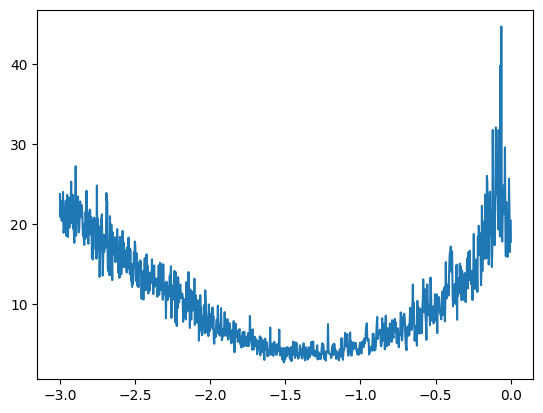

In [24]:
# Determining a good learning rate
num_steps = 1_000
learning_rates = 10**torch.linspace(-3, 0, num_steps)
batch_size = 32

learning_rate_i = []
loss_i = []

for i in range(num_steps):
    # Minibatch
    idx_batch = torch.randint(0, len(X_train), (batch_size,))

    # Forward pass
    embed = C[X_train[idx_batch]]  # (num_examples, block_size, embed_dim)
    h = torch.tanh(embed.view(-1, block_size * embed_dim) @ W1 + b1)  # (num_examples, hidden_units)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_train[idx_batch])

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Gradient update
    learning_rate = learning_rates[i]
    for p in parameters:
        p.data -= learning_rate * p.grad
    
    # Track learning rate performance
    learning_rate_i.append(learning_rate.log10().item())
    loss_i.append(loss.item())

plt.plot(learning_rate_i, loss_i)

In [25]:
# Model definition
rng = torch.Generator().manual_seed(seed)

## Parameters
### Embedding layer
C = torch.randn(len(vocab), embed_dim, generator=rng, requires_grad=True)
### Hidden layer
W1 = torch.randn(embed_dim * block_size, hidden_units, generator=rng, requires_grad=True)
b1 = torch.randn(hidden_units, generator=rng, requires_grad=True)
### Output layer
W2 = torch.randn(hidden_units, len(vocab), generator=rng, requires_grad=True)
b2 = torch.randn(len(vocab), generator=rng, requires_grad=True)

parameters = [C, W1, b1, W2, b2]
print(f"Total number of parameters in the MLP: {sum(p.numel() for p in parameters):,}")

Total number of parameters in the MLP: 10,281


1: 22.6728
10001: 2.3420
20001: 2.7854
30001: 2.3900
40001: 2.6078
50001: 2.1524
60001: 2.5864
70001: 2.1362
80001: 2.5691
90001: 2.1778


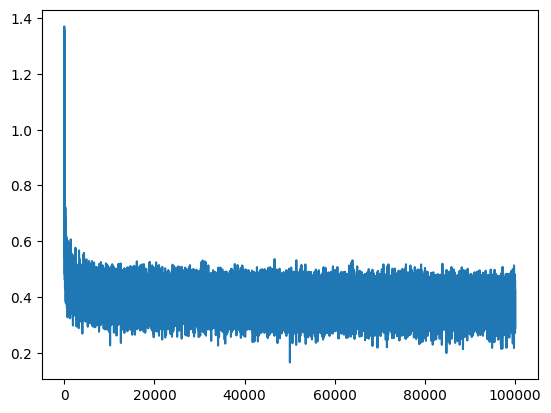

In [26]:
learning_rate = 10**-1.5
batch_size = 32

iter_i = []
loss_train_i = []

for i in range(100_000):
    # Minibatch
    idx_batch = torch.randint(0, len(X_train), (batch_size,))

    # Forward pass
    embed = C[X_train[idx_batch]]  # (num_examples, block_size, embed_dim)
    h = torch.tanh(embed.view(-1, block_size * embed_dim) @ W1 + b1)  # (num_examples, hidden_units)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_train[idx_batch])
    if i % 10_000 == 0:
        print(f"{i+1}: {loss.item():.4f}")

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Gradient update
    # decrease learning rate by a factor of 10 after every 50_000 steps
    # if i % 40_000 == 0:
    #     learning_rate /= 10
    for p in parameters:
        p.data -= learning_rate * p.grad
    
    # Track performance
    iter_i.append(i)
    loss_train_i.append(loss.log10().item())

# Plot convergence
plt.plot(iter_i, loss_train_i, label="train")

In [27]:
# Train set loss
embed = C[X_train]
h = torch.tanh(embed.view(-1, block_size * embed_dim) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_train)
print(f"Train set loss: {loss.item():.4f}")

Train set loss: 2.4151


In [28]:
# Validation set loss
embed = C[X_val]
h = torch.tanh(embed.view(-1, block_size * embed_dim) @ W1 + b1)
logits = h @ W2 + b2
loss_val = F.cross_entropy(logits, Y_val)
print(f"Validation set loss: {loss_val.item():.4f}")

Validation set loss: 2.4182


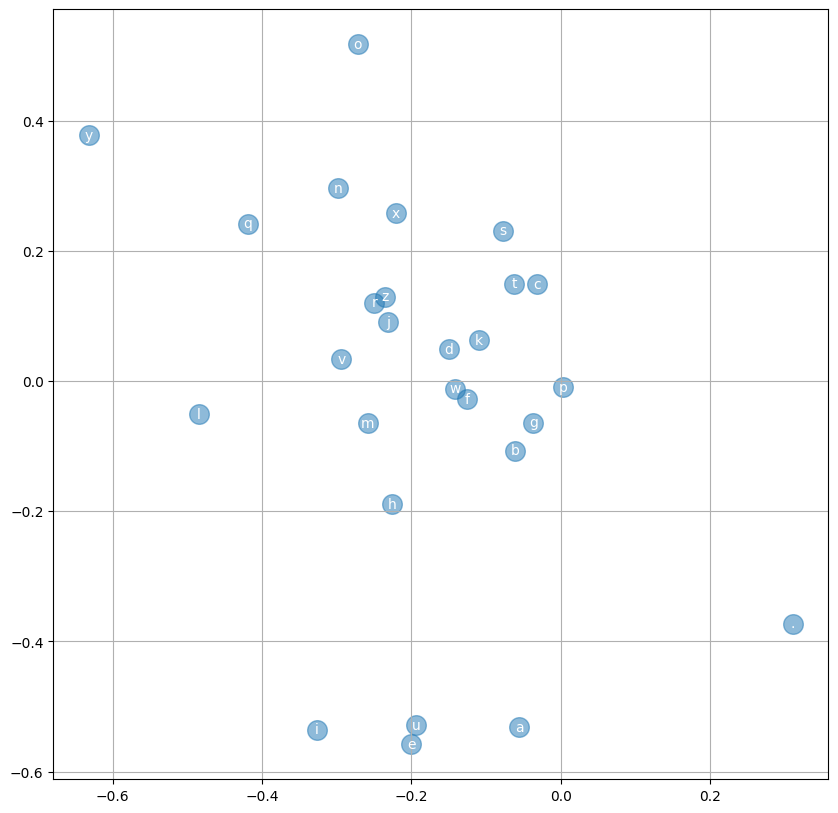

In [29]:
# Visualize embeddings
plt.figure(figsize=(10, 10))
plt.scatter(C[:, 0].data, C[:, 1].data, alpha=0.5, s=200)
for i, c in enumerate(vocab):
    plt.text(C[i, 0].item(), C[i, 1].item(), c, ha='center', va='center', color='white')
plt.grid('minor')

The vowels cluster together. `.` is isolated and far from the rest. The embeddings are clearly not random.

In [30]:
# Scale up embeddings
# Model definition
rng = torch.Generator().manual_seed(seed)

## Hyperparameters
block_size = 3
embed_dim = 100
hidden_units = 200

## Parameters
### Embedding layer
C = torch.randn(len(vocab), embed_dim, generator=rng, requires_grad=True)
### Hidden layer
W1 = torch.randn(embed_dim * block_size, hidden_units, generator=rng, requires_grad=True)
b1 = torch.randn(hidden_units, generator=rng, requires_grad=True)
### Output layer
W2 = torch.randn(hidden_units, len(vocab), generator=rng, requires_grad=True)
b2 = torch.randn(len(vocab), generator=rng, requires_grad=True)

parameters = [C, W1, b1, W2, b2]
print(f"Total number of parameters in the MLP: {sum(p.numel() for p in parameters):,}")

Total number of parameters in the MLP: 68,327


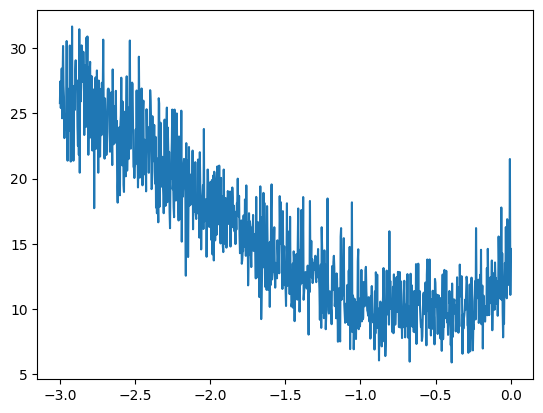

In [31]:
# Determining a good learning rate
num_steps = 1_000
learning_rates = 10**torch.linspace(-3, 0, num_steps)
batch_size = 32

learning_rate_i = []
loss_i = []

for i in range(num_steps):
    # Minibatch
    idx_batch = torch.randint(0, len(X_train), (batch_size,))

    # Forward pass
    embed = C[X_train[idx_batch]]  # (num_examples, block_size, embed_dim)
    h = torch.tanh(embed.view(-1, block_size * embed_dim) @ W1 + b1)  # (num_examples, hidden_units)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_train[idx_batch])

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Gradient update
    learning_rate = learning_rates[i]
    for p in parameters:
        p.data -= learning_rate * p.grad
    
    # Track learning rate performance
    learning_rate_i.append(learning_rate.log10().item())
    loss_i.append(loss.item())

plt.plot(learning_rate_i, loss_i)

In [32]:
# Model definition
rng = torch.Generator().manual_seed(seed)

## Parameters
### Embedding layer
C = torch.randn(len(vocab), embed_dim, generator=rng, requires_grad=True)
### Hidden layer
W1 = torch.randn(embed_dim * block_size, hidden_units, generator=rng, requires_grad=True)
b1 = torch.randn(hidden_units, generator=rng, requires_grad=True)
### Output layer
W2 = torch.randn(hidden_units, len(vocab), generator=rng, requires_grad=True)
b2 = torch.randn(len(vocab), generator=rng, requires_grad=True)

parameters = [C, W1, b1, W2, b2]
print(f"Total number of parameters in the MLP: {sum(p.numel() for p in parameters):,}")

Total number of parameters in the MLP: 68,327


1: 25.2422
10001: 2.9656
20001: 2.9483
30001: 3.2608
40001: 3.1154
50001: 2.4138
60001: 2.6891
70001: 2.8073
80001: 2.7322
90001: 3.2410
100001: 2.0732
110001: 2.1702
120001: 2.3489
130001: 2.2249
140001: 1.9117
150001: 1.7889
160001: 1.9513
170001: 2.0335
180001: 2.3048
190001: 2.4682


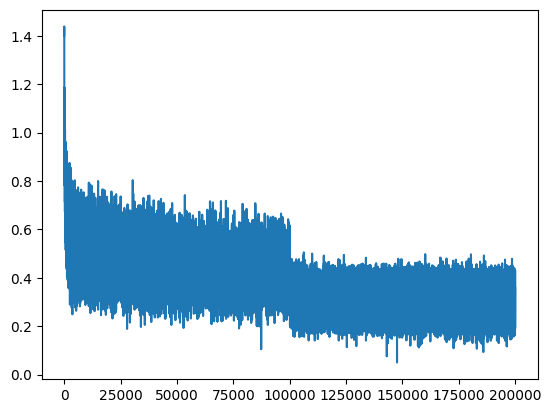

In [33]:
batch_size = 32

iter_i = []
loss_train_i = []

for i in range(200_000):
    # Minibatch
    idx_batch = torch.randint(0, len(X_train), (batch_size,))

    # Forward pass
    embed = C[X_train[idx_batch]]  # (num_examples, block_size, embed_dim)
    h = torch.tanh(embed.view(-1, block_size * embed_dim) @ W1 + b1)  # (num_examples, hidden_units)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_train[idx_batch])
    if i % 10_000 == 0:
        print(f"{i+1}: {loss.item():.4f}")

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Gradient update
    # decrease learning rate by a factor of 10 after every 50_000 steps
    learning_rate = 10**-0.5 if i < 100_000 else 10**-1.5
    for p in parameters:
        p.data -= learning_rate * p.grad
    
    # Track performance
    iter_i.append(i)
    loss_train_i.append(loss.log10().item())

# Plot convergence
plt.plot(iter_i, loss_train_i, label="train")

In [34]:
# Train set loss
embed = C[X_train]
h = torch.tanh(embed.view(-1, block_size * embed_dim) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_train)
print(f"Train set loss: {loss.item():.4f}")

Train set loss: 2.0633


In [35]:
# Validation set loss
embed = C[X_val]
h = torch.tanh(embed.view(-1, block_size * embed_dim) @ W1 + b1)
logits = h @ W2 + b2
loss_val = F.cross_entropy(logits, Y_val)
print(f"Validation set loss: {loss_val.item():.4f}")

Validation set loss: 2.1476


## Sampling new names

In [36]:
rng = torch.Generator().manual_seed(seed)
num_names = 10

for _ in range(num_names):
    name = []
    context = [0] * block_size
    while True:
        embed = C[torch.tensor([context])]
        h = torch.tanh(embed.view(-1, block_size * embed_dim) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=-1)
        next_char_ix = torch.multinomial(probs[-1], num_samples=1, generator=rng).item()
        context = context[1:] + [next_char_ix]
        name.append(ix_to_char[next_char_ix])
        if next_char_ix == 0:
            break
    print("".join(name))

kendayvia.
zil.
imberlyng.
yace.
zyia.
treu.
rito.
obles.
byun.
acvinegarriany.
